In [ ]:
# Read images
import os
import glob
# read mages from vehicles/ directory
def read_images(arr,img_dir):
    image_dir = img_dir
    image_folders = os.listdir(image_dir)
    for folder in image_filders:
        arr.extend()

cars = []
image_dir = 'vehicles/'
images_types = os.listdir(image_dir)
for imtype in images_types:
    cars.extend(glob.glob(image_dir+imtype+'/*'))

print('Number of Veicles Images found : ', len(cars))
with open("cars.txt", 'w') as f:
    for fn in cars:
        f.write(fn+'\n')

# read non-vehicle images 
noncars = []
image_dir = 'non-vehicles/'
images_types = os.listdir(image_dir)
for imtype in images_types:
    noncars.extend(glob.glob(image_dir+imtype+'/*'))

print('Number of Non-Veicles Images found : ', len(noncars))
with open("noncars.txt", 'w') as f:
    for fn in noncars:
        f.write(fn+'\n')

In [2]:
import cv2
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import numpy as np
import time
from skimage.feature import hog
from sklearn.svm import LinearSVC
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
#from sklearn.cross_validation import train_test_split

In [66]:
# HOG features
def get_hog_features(img, orient, pix_per_cell, cell_per_block, 
                    vis=False, feature_vec=True):
    if vis == True:
        features, hog_image = hog(img, orientations=orient,
                                 pixels_per_cell=(pix_per_cell, pix_per_cell),
                                 cells_per_block=(cell_per_block, cell_per_block),
                                 transform_sqrt=False,
                                 visualise=vis, feature_vector=feature_vec)
        return features, hog_image
    else:
        features = hog(img, orientations=orient,
                                 pixels_per_cell=(pix_per_cell, pix_per_cell),
                                 cells_per_block=(cell_per_block, cell_per_block),
                                 transform_sqrt=False,
                                 visualise=vis, feature_vector=feature_vec)
        return features

# down-sampling the image.
def bin_spatial(img, size=(32,32)):
    color1 = cv2.resize(img[:,:,0], size).ravel()
    color2 = cv2.resize(img[:,:,1], size).ravel()
    color3 = cv2.resize(img[:,:,2], size).ravel()
    return np.hstack((color1, color2, color3))

# Define a function to compute color histgram features
def color_hist(img, nbins=32):  #bins_range=(0,256)
    #compute the historgram of the color channels separately
    channel1_hist = np.histogram(img[:,:,0], bins=nbins)
    channel2_hist = np.histogram(img[:,:,1], bins=nbins)
    channel3_hist = np.histogram(img[:,:,2], bins=nbins)
    # concatenate the histograms into a single feature vector
    hist_features = np.concatenate((channel1_hist[0], channel2_hist[0], channel3_hist[0]))
    return hist_features


###
def extract_features(imgs, color_space='RGB', spatial_size=(32,32),
                     hist_bins=32, orient=9,
                     pix_per_cell=8, cell_per_block=2, hog_channel=0,
                     spatial_feat=True, hist_feat=True, hog_feat=True):
    
    # Create a list to append feature vectors to
    features = []
    # Iterate through the list of images
    for file in imgs:
        file_features = []
        # Read in each one by one
        image = mpimg.imread(file)
        # apply color conversion if other than 'RGB'
        if cspace != 'RGB':
            if cspace == 'HSV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2HSV)
            elif cspace == 'LUV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2LUV)
            elif cspace == 'HLS':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2HLS)
            elif cspace == 'YUV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2YUV)
            elif cspace == 'YCrCb':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2YCrCb)
        else: feature_image = np.copy(image)

        if spatial_feat == True:
            spatial_features = bin_spatial(feature_image, size=spatial_size)
            file_features.append(spatial_features)

        if hist_feat == True:
            # Apply color_hist
            hist_features = color_hist(feature_image, nbins=hist_bins)
            hist_features=((np.array(hist_features))/(max(hist_features))).astype('float32')

            file_features.append(hist_features)

        if hog_feat == True:
            if hog_channel == 'ALL':
                hog_features = []
                for channel in range(feature_image.shape[2]):
                    hog_features.append(get_hog_features1(feature_image[:,:,channel],
                                        orient, pix_per_cell, cell_per_block,
                                        vis=False, feature_vec=True))
                hog_features = np.ravel(hog_features)
            else:
                hog_features = get_hog_features1(feature_image[:,:,hog_channel], orient,
                            pix_per_cell, cell_per_block, vis=False, feature_vec=True)
            file_features.append(hog_features)
        features.append(np.concatenate(file_features))
    # Return list of feature vectors
    return features

def slide_window(img, x_start_stop=[None, None], y_start_stop=[None, None], 
                    xy_window=(64, 64), xy_overlap=(0.5, 0.5)):
    # If x and/or y start/stop positions not defined, set to image size
    if x_start_stop[0] == None:
        x_start_stop[0] = 0
    if x_start_stop[1] == None:
        x_start_stop[1] = img.shape[1]
    if y_start_stop[0] == None:
        y_start_stop[0] = 0
    if y_start_stop[1] == None:
        y_start_stop[1] = img.shape[0]
    # Compute the span of the region to be searched    
    xspan = x_start_stop[1] - x_start_stop[0]
    yspan = y_start_stop[1] - y_start_stop[0]
    # Compute the number of pixels per step in x/y
    nx_pix_per_step = np.int(xy_window[0]*(1 - xy_overlap[0]))
    ny_pix_per_step = np.int(xy_window[1]*(1 - xy_overlap[1]))
    # Compute the number of windows in x/y
    nx_buffer = np.int(xy_window[0]*(xy_overlap[0]))
    ny_buffer = np.int(xy_window[1]*(xy_overlap[1]))
    nx_windows = np.int((xspan-nx_buffer)/nx_pix_per_step) 
    ny_windows = np.int((yspan-ny_buffer)/ny_pix_per_step) 
    # Initialize a list to append window positions to
    window_list = []
    # Loop through finding x and y window positions
    # Note: you could vectorize this step, but in practice
    # you'll be considering windows one by one with your
    # classifier, so looping makes sense
    for ys in range(ny_windows):
        for xs in range(nx_windows):
            # Calculate window position
            startx = xs*nx_pix_per_step + x_start_stop[0]
            endx = startx + xy_window[0]
            starty = ys*ny_pix_per_step + y_start_stop[0]
            endy = starty + xy_window[1]
            # Append window position to list
            window_list.append(((startx, starty), (endx, endy)))
    # Return the list of windows
    return window_list

# define a funciton to draw boxes
def draw_boxes(img, bboxes, color=(0,0,255), thick=6):
    # make a copy of image
    imcopy = np.copy(img)
    # iterate through the bounding boxes
    for bbox in bboxes:
        # draw a rectangle given bbox coordinates
        cv2.rectangle(imcopy, bbox[0], bbox[1], color, thick)
    # return the image copy with boxes drawn
    return imcopy

# define a function to extract features from a single image window
# this function is very similar to extract_features()
# just for a single image rather than list of images
def single_img_features(img, color_space='RGB', spatial_size=(32,32),
                       hist_bins=32, orient=9,
                       pix_per_cell=8, cell_per_block=2, hog_channel=0,
                       spatial_feat=True, hist_feat=True, hog_feat=True, vis=False):
    # define an empty list to receive features
    img_features = []
    # apply color conversion if other than 'RGB'
    if color_space != 'RGB':
        if color_space == 'HSV':
            feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2HSV)
        if color_space == 'LUV':
            feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2LUV)
        if color_space == 'HLS':
            feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2HLS)
        if color_space == 'YUV':
            feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2YUV)
        if color_space == 'YCrCb':
            feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2YCrCb)
    else:
        feature_image = np.copy(img)
    # compare spatial features if flag is set
    if spatial_feat == True:
        spatial_features = bin_spatial(feature_image, size=spatial_size)
        img_features.append(spatial_features)
    if hist_feat == True:
        hist_features = color_hist(feature_image, nbins=hist_bins)
        img_features.append(hist_features)
    if hog_feat == True:
        if hog_channel == 'ALL':
            hog_features = []
            for channel in range(feature_image.shape[2]):
                hog_features.append(get_hog, faturs(feature_image[:,:,channel],
                                                  orient, pix_per_cell, cell_per_block,
                                                  vis=False, feature_vec=True))
            hog_features = np.ravel(hog_features)
        else:
            if vis == True:
                hog_features, hog_image = get_hog_features(feature_image[:,:,hog_channel], orient,
                                           pix_per_cell, cell_per_block, vis=True,
                                           feature_vec=True)
            else:
                hog_features = get_hog_features(feature_image[:,:,hog_channel], orient,
                                           pix_per_cell, cell_per_block, vis=False,
                                           feature_vec=True)
        img_features.append(hog_features)
    if vis == True:
        return np.concatenate(img_features), hog_image
    else:
        return np.concatenate(img_features)
    
# Define a function you will pass an image 
# and the list of windows to be searched (output of slide_windows())
def search_windows(img, windows, clf, scaler, color_space='RGB', 
                    spatial_size=(32, 32), hist_bins=32, 
                    hist_range=(0, 256), orient=9, 
                    pix_per_cell=8, cell_per_block=2, 
                    hog_channel=0, spatial_feat=True, 
                    hist_feat=True, hog_feat=True):

    #1) Create an empty list to receive positive detection windows
    on_windows = []
    #2) Iterate over all windows in the list
    for window in windows:
        #3) Extract the test window from original image
        test_img = cv2.resize(img[window[0][1]:window[1][1], window[0][0]:window[1][0]], (64, 64))      
        #4) Extract features for that window using single_img_features()
        features = single_img_features(test_img, color_space=color_space, 
                            spatial_size=spatial_size, hist_bins=hist_bins, 
                            orient=orient, pix_per_cell=pix_per_cell, 
                            cell_per_block=cell_per_block, 
                            hog_channel=hog_channel, spatial_feat=spatial_feat, 
                            hist_feat=hist_feat, hog_feat=hog_feat)
        #5) Scale extracted features to be fed to classifier
        test_features = scaler.transform(np.array(features).reshape(1, -1))
        #6) Predict using your classifier
        prediction = clf.predict(test_features)
        #7) If positive (prediction == 1) then save the window
        if prediction == 1:
            on_windows.append(window)
    #8) Return windows for positive detections
    return on_windows
                                  
def visualize(fig, rows, cols, imgs, titles):
    for i, img in enumerate(imgs):
        plt.subplot(rows, cols, i+1)
        plt.title(i+1)
        img_dims = len(img.shape)
        if img_dims < 3:
            plt.imshow(img, cmap='hot')
            plt.title(titles[i])
        else:
            plt.imshow(img)
            plt.title(titles[i])

        

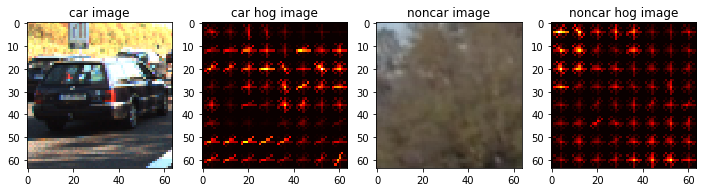

In [4]:
%matplotlib inline

# choose random car/non-car indices:
car_ind = np.random.randint(0, len(cars))
noncar_ind = np.random.randint(0, len(noncars))

# read in car / non-car images
car_image = mpimg.imread(cars[car_ind])
noncar_image = mpimg.imread(noncars[noncar_ind])

# define feature parameters
color_space = 'RGB' # can be RGB, HSV, etc.
orient = 6
pix_per_cell = 8
cell_per_block = 2
hog_channel = 0 # can be 0, 1, 2, or 'ALL'
spatial_size = (16, 16)
hist_bins = 16
spatial_feat = True
hist_feat = True
hog_feat = True

car_features, car_hog_image= single_img_features(car_image,color_space=color_space,
                                                 spatial_size=spatial_size,hist_bins=hist_bins,
                                                 orient=orient,pix_per_cell=pix_per_cell,
                                                 cell_per_block=cell_per_block,
                                                 hog_channel=hog_channel,spatial_feat=spatial_feat,
                                                 hist_feat=hist_feat,hog_feat=hog_feat,vis=True)

notcar_features, noncar_hog_image= single_img_features(noncar_image,color_space=color_space,
                                                 spatial_size=spatial_size,hist_bins=hist_bins,
                                                 orient=orient,pix_per_cell=pix_per_cell,
                                                 cell_per_block=cell_per_block,
                                                 hog_channel=hog_channel,spatial_feat=spatial_feat,
                                                 hist_feat=hist_feat,hog_feat=hog_feat,vis=True)

images = [car_image, car_hog_image, noncar_image, noncar_hog_image]
titles = ['car image', 'car hog image', 'noncar image', 'noncar hog image']

fig = plt.figure(figsize=(12,3))
visualize(fig, 1, 4, images, titles)

In [5]:
# Define feature parameters
# need to explain why these parameters are selected. 
# play with color_space
color_space = 'RGB'
# may use up to 9?
orient = 6
pix_per_cell = 8
cell_per_block = 2
# change hog_channel to ALL?
hog_channel = 0 # can be 0, 1, 2, or 'ALL'
# change spatial_size to 32, 32
spatial_size = (16, 16)
hist_bins = 16
spatial_feat = True
hist_feat = True
hog_feat = True

t=time.time()
n_samples = 1000
random_idxs = np.random.randint(0,len(cars),n_samples)
test_cars = np.array(cars)[random_idxs]
test_notcars = np.array(noncars)[random_idxs]

car_features = extract_features(test_cars,color_space=color_space,
                                                 spatial_size=spatial_size,hist_bins=hist_bins,
                                                 orient=orient,pix_per_cell=pix_per_cell,
                                                 cell_per_block=cell_per_block,
                                                 hog_channel=hog_channel,spatial_feat=spatial_feat,
                                                 hist_feat=hist_feat,hog_feat=hog_feat)

notcar_features = extract_features(test_notcars,color_space=color_space,
                                                 spatial_size=spatial_size,hist_bins=hist_bins,
                                                 orient=orient,pix_per_cell=pix_per_cell,
                                                 cell_per_block=cell_per_block,
                                                 hog_channel=hog_channel,spatial_feat=spatial_feat,
                                                 hist_feat=hist_feat,hog_feat=hog_feat)

print(time.time()-t, 'Seconds to compute features...')

X = np.vstack((car_features, notcar_features)).astype(np.float64)
# fit a per-column scaler
X_scaler = StandardScaler().fit(X)
# apply the scaler to X
scaled_X = X_scaler.transform(X)

# define the labels vector
y = np.hstack((np.ones(len(car_features)), np.zeros(len(notcar_features))))

# split up data into randomized training and test sets
rand_state = np.random.randint(0, 100)
X_train, X_test, y_train, y_test = train_test_split(
    scaled_X, y, test_size=0.1, random_state=rand_state)

print('Using:', orient, 'orientations,', pix_per_cell,
     'pixels per cell,', cell_per_block, 'cells per block,',
     hist_bins, 'histogram bins, and ', spatial_size, 'spatial_sampling.')
print('Feature vector length:', len(X_train[0]))

# use a linear SVC
svc = LinearSVC()
# check the training time for the SVC
t = time.time()
svc.fit(X_train, y_train)
print(round(time.time()-t, 2), ' Seconds to train svc...')
# check the score of the SVC
print('Test accuracy of SVC = ', round(svc.score(X_test, y_test), 4))

33.11971306800842 Seconds to compute features...
Using: 6 orientations, 8 pixels per cell, 2 cells per block, 16 histogram bins, and  (16, 16) spatial_sampling.
Feature vector length: 1992
2.34  Seconds to train svc...
Test accuracy of SVC =  0.96


0.29730796813964844 seconds to process one image searching 57 windows
0.22381114959716797 seconds to process one image searching 57 windows
0.2111649513244629 seconds to process one image searching 57 windows
0.20281195640563965 seconds to process one image searching 57 windows
0.25433802604675293 seconds to process one image searching 57 windows
0.2094581127166748 seconds to process one image searching 57 windows


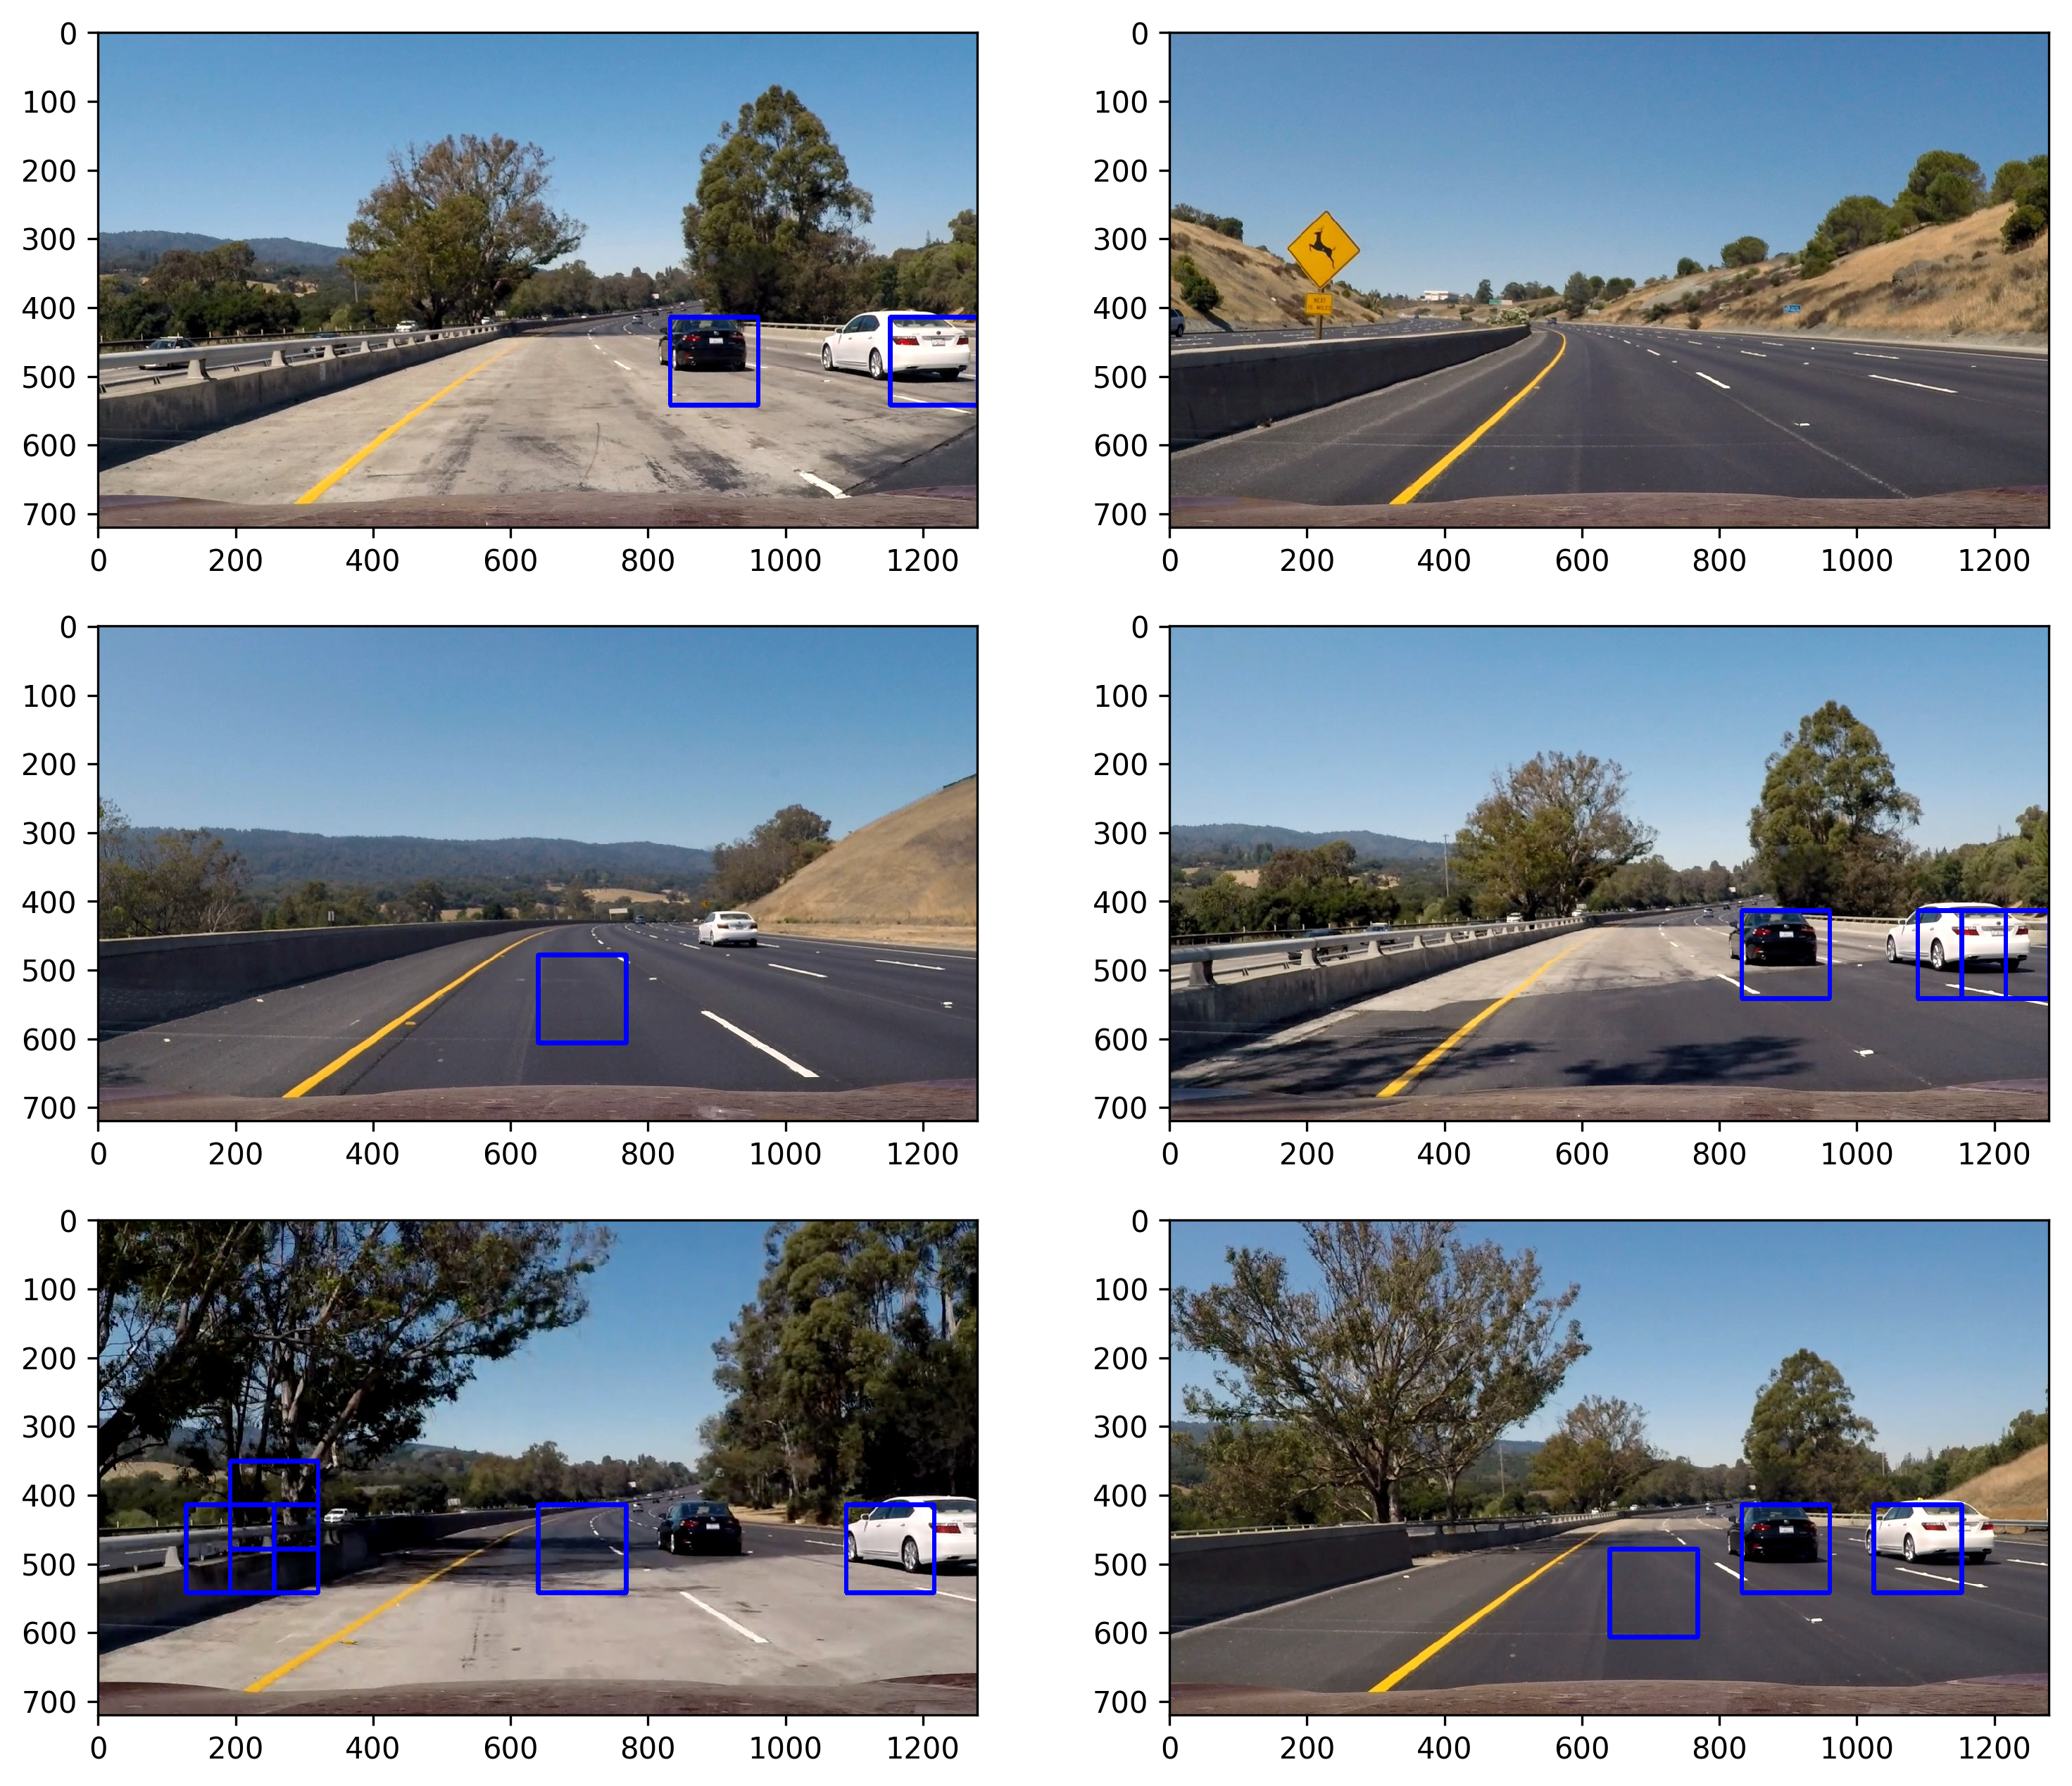

In [39]:
searchpath = 'test_images/*'
example_images = glob.glob(searchpath)
images = []
titles = []
#y_start_stop = [None, None] # min and max in y to search
y_start_stop = [350, 606]
overlap = 0.5
for img_src in example_images:
    t1 = time.time()
    img = mpimg.imread(img_src)
    draw_img = np.copy(img)
    img = img.astype(np.float32)/255
    
    windows = slide_window(img, x_start_stop=[None, None], y_start_stop=y_start_stop,
                            xy_window=(128,128), xy_overlap=(overlap,overlap))
    
    hot_windows = search_windows(img, windows, svc, X_scaler, color_space=color_space,
                          spatial_size=spatial_size, hist_bins=hist_bins,
                          orient=orient, pix_per_cell=pix_per_cell,
                          cell_per_block=cell_per_block,
                          hog_channel=hog_channel, spatial_feat=spatial_feat,
                          hist_feat=hist_feat, hog_feat=hog_feat)
    
    window_img = draw_boxes(draw_img, hot_windows, color=(0,0,255), thick=6)
    images.append(window_img)
    titles.append('')
    print(time.time()-t1, 'seconds to process one image searching', len(windows),'windows')
fig = plt.figure(figsize=(12,18), dpi=300)
visualize(fig,5,2,images,titles)
    

In [40]:
def convert_color(img, conv='RGB2YCrCb'):
    if conv == 'RGB2YCrCb':
        return cv2.cvtColor(img, cv2.COLOR_RGB2YCrCb)
    if conv == 'BGR2YCrCb':
        return cv2.cvtColor(img, cv2.COLOR_BGR2YCrCb)
    if conv == 'RGB2LUV':
        return cv2.cvtColor(img, cv2.COLOR_RGB2LUV)

In [73]:
out_images = []
out_maps = []
out_titles = []
out_boxes = []

ystart = 400
ystop = 656
scale = 1 # using to change the window size 64, 96, 128,...

# iterate over test images
for img_src in example_images:
    img_boxes = []
    t = time.time()
    count = 0
    img = mpimg.imread(img_src)
    draw_img = np.copy(img)
    # make a heatmap of zeros
    heatmap = np.zeros_like(img[:,:,0])
    img = img.astype(np.float32)/255
    
    img_tosearch = img[ystart:ystop,:,:]
    ctrans_tosearch = convert_color(img_tosearch, conv='RGB2YCrCb')
    if scale != 1:
        imshape = ctrans_tosearch.shape
        ctrans_tosearch = cv2.resize(ctrans_search, (np.int(imshape[1]/scale), 
                                                     np.int(imshape[0]/scale)))
    
    ch1 = ctrans_tosearch[:,:,0]
    ch2 = ctrans_tosearch[:,:,1]
    ch3 = ctrans_tosearch[:,:,2]
    
    nxblocks = (ch1.shape[1] // pix_per_cell) - 1
    nyblocks = (ch1.shape[0] // pix_per_cell) - 1
    nfeat_per_block = orient*cell_per_block**2
    window = 64
    nblocks_per_window = (window // pix_per_cell) - 1
    cells_per_step = 2 # instead of defininig overlap, define how many cells to step 
    nxsteps = (nxblocks - nblocks_per_window) // cells_per_step
    nysteps = (nyblocks - nblocks_per_window) // cells_per_step
    
    hog1 = get_hog_features(ch1, orient, pix_per_cell, cell_per_block, feature_vec=False)
    hog2 = get_hog_features(ch2, orient, pix_per_cell, cell_per_block, feature_vec=False)
    hog3 = get_hog_features(ch3, orient, pix_per_cell, cell_per_block, feature_vec=False)
    
    for xb in range(nxsteps):
        for yb in range(nysteps):
            count += 1
            ypos = yb*cells_per_step
            xpos = xb*cells_per_step
            hog_feat1 = hog1[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel()
            hog_feat2 = hog2[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel()
            hog_feat3 = hog3[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel()
            hog_features = np.hstack((hog_feat1, hog_feat2, hog_feat3))
            
            xleft = xpos*pix_per_cell
            ytop = ypos*pix_per_cell
            
            # extract the image patch
            subimg = cv2.resize(ctrans_tosearch[ytop:ytop+window, xleft:xleft+window], (64, 64))
            
            # get color features
            spatial_features = bin_spatial(subimg, size=spatial_size)
            hist_features = color_hist(subimg, nbins=hist_bins)
            
            # scale features and make a predition
            test_features = X_scaler.transform(np.hstack((spatial_features, 
                                                          hist_features, hog_feat1)).reshape(1,-1))

            test_prediction = svc.predict(test_features)
            
            if test_prediction == 1:
                xbox_left = np.int(xleft*scale)
                ytop_draw = np.int(ytop*scale)
                win_draw = np.int(window*scale)
                cv2.rectangle(draw_img, (xbox_left, ytop_draw+ystart),(xbox_left+win_draw, ytop_draw+win_draw+ystart),(0,0,255))
                img_boxes.append(((xbox_left, ytop_draw+ystart), (xbox_left+win_draw,ytop_draw+win_draw+ystart)))
                heatmap[ytop_draw+ystart:ytop_draw+win_draw+ystart, xbox_left:xbox_left+win_draw] += 1
            
        print(time.time()-t, 'seconds to run, total windows = ', count)
        
        out_images.append(draw_img)
            
        out_titles.append(img_src[-12:])
        out_titles.append(img_src[-12:])
        out_images.append(heatmap)
        out_maps.append(heatmap)
        out_boxes.append(img_boxes)
        
    #fit=plt.figure(figsize=(12,24))
    #visualize(fig, 8, 2, out_images, out_titles)
    

0.5428750514984131 seconds to run, total windows =  12
0.5586230754852295 seconds to run, total windows =  24
0.572645902633667 seconds to run, total windows =  36
0.5874419212341309 seconds to run, total windows =  48
0.5993070602416992 seconds to run, total windows =  60
0.6107840538024902 seconds to run, total windows =  72
0.6241700649261475 seconds to run, total windows =  84
0.6361339092254639 seconds to run, total windows =  96
0.6470460891723633 seconds to run, total windows =  108
0.658811092376709 seconds to run, total windows =  120
0.6746559143066406 seconds to run, total windows =  132
0.6851480007171631 seconds to run, total windows =  144
0.7029938697814941 seconds to run, total windows =  156
0.7142589092254639 seconds to run, total windows =  168
0.7245469093322754 seconds to run, total windows =  180
0.7359070777893066 seconds to run, total windows =  192
0.747999906539917 seconds to run, total windows =  204
0.7603240013122559 seconds to run, total windows =  216
0.7

In [ ]:
from scipy.ndimage.measurements import label

def apply_threshold(heatmap, threshold):
    heatmap[heatmap <= threshold] = 0
    return heatmap

def draw_labeld_bboxes(img, labesls):
    for car_number in range(1, labels[1]+1):
        nonzero = (labels[0] == car_number).nonzero()
        nonzeroy = np.array(nonzero[0])
        nonzerox = np.array(nonzero[1])
        
        bbox = ((np.min(nonzerox), np.min(nonzeroy)), (np.max(nonzerox), np.max(nonzeroy)))
        cv2.rectangle(img, bbox[0], bbox[1], (0,0,255), 6)
    return img

In [49]:
out_image = []
out_maps = []
ystart = 400
ystop = 656
scale = 1
# iterate over test images
for img_src in example_images:
    img = mpimg.imread(img_src)
    out_img, heat_map = find_cars(img, scale)
    labels = label(heat_map)
    draw_img = draw_labeled_bboxes(np.copy(img), labels)
    out_images.append(draw_img)
    out_images.append(heat_map)

fig = plt.figure(figsize=(12,24))
visualize(fig, 8, 2, out_images, out_titles)

NameError: name 'find_cars' is not defined

In [50]:
def process_image(img):
    out_img, heat_map = find_cars(img, scale)
    labels = label(heat_map)
    draw_img = draw_labeled_bboxes(np.copy(img), labels)
    return draw_img

In [ ]:
from moviepy.editor import videoFileClip
from IPython.display import HTML

test_output = "test_output.mp4"
clip = videoFileClip("test_video.mp4")
test_clip = clip.f1_image(process_image)
test_clip.write_videofile(test_output, audio=False)